### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 1850-2014

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris
from eofs.iris import Eof

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 180
lat = 90

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

,longitude,latitude,t,loc
0,1.0,-89.0,1.0,911.0
1,3.0,-89.0,1.0,2911.0
2,5.0,-89.0,1.0,4911.0
3,7.0,-89.0,1.0,6911.0
4,9.0,-89.0,1.0,8911.0
...,...,...,...,...
971995,351.0,89.0,60.0,351089.0
971996,353.0,89.0,60.0,353089.0
971997,355.0,89.0,60.0,355089.0
971998,357.0,89.0,60.0,357089.0


#### 1.1. Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [7]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3prod_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [8]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3loss_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 2.1. Import total NO${_X}$ emission 

In [9]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/eminox_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'eminox')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
nox = values.reshape(t*lon*lat,1)
dataset['eminox'] = nox

#### 2.2. Import total VOC emission

In [10]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/emivoc_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'emivoc')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
voc = values.reshape(t*lon*lat,1)
dataset['emivoc'] = voc

#### 3.1. Import near-surface air temperature

In [11]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.2. Import ambient air humidity

In [12]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/hus_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'hus')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:,:]
data = data.collapsed('air_pressure', iris.analysis.MAX)
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hus = values.reshape(t*lon*lat,1)
dataset['hus'] = hus

#### 3.3. Import aerosol optical depth at 550 nm

In [13]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/abs550aer_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'abs550aer')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
aod = values.reshape(t*lon*lat,1)
dataset['aod'] = aod

#### 3.4. Import planetary boundary layer height

In [14]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/bldep_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'bldep')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pbl = values.reshape(t*lon*lat,1)
dataset['bldep'] = pbl

#### 3.5. Import eastward wind speed

In [15]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/ua_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'ua')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ua = values.reshape(t*lon*lat,1)
dataset['ua'] = ua

#### 3.6. Import northward wind speed

In [16]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/va_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'va')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
va = values.reshape(t*lon*lat,1)
dataset['va'] = va

#### 4.1. Import NO${_2}$ photolysis rate

In [17]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/jno2_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [18]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/photo1d_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

In [19]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/lossch4_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [20]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/lossco_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [21]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/no2_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [22]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/no_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [23]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/oh_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.4. Import H${_2}$O concentration

In [24]:
data = iris.load_cube('/Volumes/Database/CMIP6/NCAR/CESM2-WACCM-FV2/historical/h2o_AERmon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_200001-201412.nc', 'h2o')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,69,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
h2o = values.reshape(t*lon*lat,1)
dataset['h2o'] = h2o

#### 5.5. Import PAN reservoir concentration

In [25]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/pan_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'pan')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pan = values.reshape(t*lon*lat,1)
dataset['pan'] = pan

#### 5.6. Import HNO${_3}$ reservoir concentration

In [26]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/hno3_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'hno3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hno3 = values.reshape(t*lon*lat,1)
dataset['hno3'] = hno3

#### We should convert 0-360° into 180°W-180°E scheme

In [27]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

,longitude,latitude,t,loc,o3,o3prod,o3loss,eminox,emivoc,tas,...,jno2,photo1d,lossch4,lossco,no2,no,oh,h2o,pan,hno3
0,1.0,-89.0,1.0,911.0,1.589701e-08,8.802798e-14,9.406584e-14,0.000000e+00,0.000000e+00,249.576233,...,0.009999,0.000009,5.311195e-14,1.277250e-13,8.882154e-13,2.529135e-12,2.217255e-14,0.000583,1.948163e-11,4.902149e-12
1,3.0,-89.0,1.0,2911.0,1.590375e-08,8.794498e-14,9.389479e-14,0.000000e+00,0.000000e+00,249.540802,...,0.009996,0.000009,5.298542e-14,1.275324e-13,8.887986e-13,2.531392e-12,2.216382e-14,0.000581,1.948889e-11,4.917698e-12
2,5.0,-89.0,1.0,4911.0,1.591221e-08,8.791484e-14,9.379763e-14,0.000000e+00,0.000000e+00,249.509583,...,0.009992,0.000009,5.289758e-14,1.274182e-13,8.893592e-13,2.533313e-12,2.215777e-14,0.000578,1.949726e-11,4.934536e-12
3,7.0,-89.0,1.0,6911.0,1.594265e-08,8.803169e-14,9.397011e-14,0.000000e+00,0.000000e+00,249.491928,...,0.009982,0.000009,5.295365e-14,1.276653e-13,8.915080e-13,2.536377e-12,2.219409e-14,0.000576,1.952172e-11,4.985100e-12
4,9.0,-89.0,1.0,8911.0,1.596177e-08,8.795628e-14,9.384050e-14,0.000000e+00,0.000000e+00,249.463867,...,0.009968,0.000009,5.284644e-14,1.275174e-13,8.936179e-13,2.538650e-12,2.219230e-14,0.000573,1.953937e-11,5.026847e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971995,-9.0,89.0,60.0,351089.0,1.630996e-08,2.842892e-16,1.809345e-16,3.336417e-13,6.572778e-15,242.579666,...,0.000000,0.000000,2.344622e-17,1.539477e-16,2.944786e-11,3.544725e-12,4.284533e-18,0.000496,6.142603e-11,1.823110e-10
971996,-7.0,89.0,60.0,353089.0,1.632853e-08,2.287422e-16,1.680337e-16,1.499039e-13,2.951658e-15,242.593552,...,0.000000,0.000000,2.114953e-17,1.391508e-16,2.916738e-11,2.147857e-12,4.259052e-18,0.000495,6.147796e-11,1.823462e-10
971997,-5.0,89.0,60.0,355089.0,1.634956e-08,1.920444e-16,1.595247e-16,1.640803e-14,3.207111e-16,242.609467,...,0.000000,0.000000,1.963665e-17,1.295937e-16,2.885089e-11,1.215968e-12,4.220461e-18,0.000493,6.153731e-11,1.824153e-10
971998,-3.0,89.0,60.0,357089.0,1.636259e-08,2.303925e-16,1.698968e-16,3.794615e-14,7.451860e-16,242.615997,...,0.000000,0.000000,2.147886e-17,1.419528e-16,2.942249e-11,1.743065e-12,4.380438e-18,0.000492,6.157401e-11,1.824549e-10


#### Calculate the kinetic rates

In [28]:
dataset_adj['k_no_ho2']   = 3.30*10**(-12)*np.exp(270/dataset_adj['tas'])
dataset_adj['k_no_ch3o2'] = 2.30*10**(-12)*np.exp(360/dataset_adj['tas'])
dataset_adj['k_o1d_h2o']  = 1.63*10**(-10)*np.exp(60/dataset_adj['tas'])
dataset_adj['k_o3_ho2']   = 2.03*10**(-16)*(dataset_adj['tas']/300)**4.57*np.exp(693/dataset_adj['tas'])
dataset_adj['k_o3_oh']    = 1.70*10**(-12)*np.exp(-940/dataset_adj['tas'])

#### Calculate the procedural auxilliary variables 
##### where K1's are aggressive approach to use as many associated variables as possible 
##### and K2's are conservative approach to only use variables that we trust the credibility 

In [29]:
dataset_adj['K1_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no'] * dataset_adj['lossco']
dataset_adj['K1_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no'] * dataset_adj['lossch4']
dataset_adj['K1_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3'] * dataset_adj['hus']
dataset_adj['K1_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K1_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3'] * dataset_adj['lossco']

In [30]:
dataset_adj['K2_NO_HO2']   = dataset_adj['k_no_ho2'] * dataset_adj['no']
dataset_adj['K2_NO_CH3O2'] = dataset_adj['k_no_ch3o2'] * dataset_adj['no']
dataset_adj['K2_O1D_H2O']  = dataset_adj['k_o1d_h2o'] * dataset_adj['photo1d'] * dataset_adj['o3']
dataset_adj['K2_O3_OH']    = dataset_adj['k_o3_oh'] * dataset_adj['o3'] * dataset_adj['oh'] 
dataset_adj['K2_O3_HO2']   = dataset_adj['k_o3_ho2'] * dataset_adj['o3']

In [31]:
dataset_adj.to_csv('/Volumes/Database/Research/C7 Multivariate analysis/UKESM1-0-LL_diag_2014(0301).csv', index = False)
#dataset_adj.to_stata('/Volumes/Database/Research/C7 Multivariate analysis/UKESM1-0-LL_diag_2014(1119).dta')

### Map the variables to ensure correct gridding

(-90.0, 90.0)

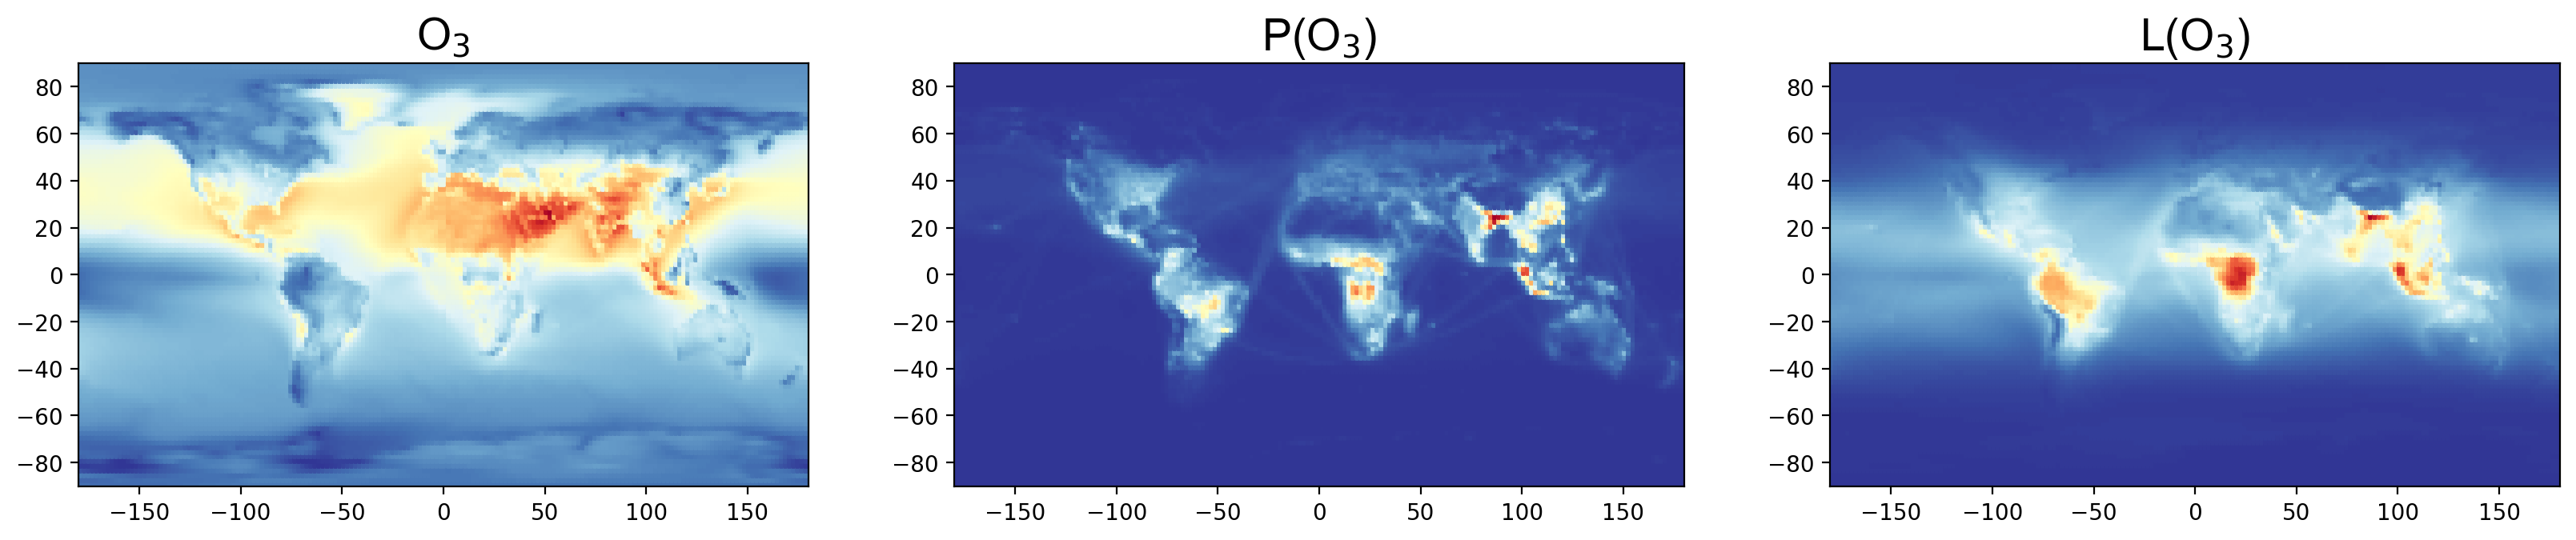

In [32]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

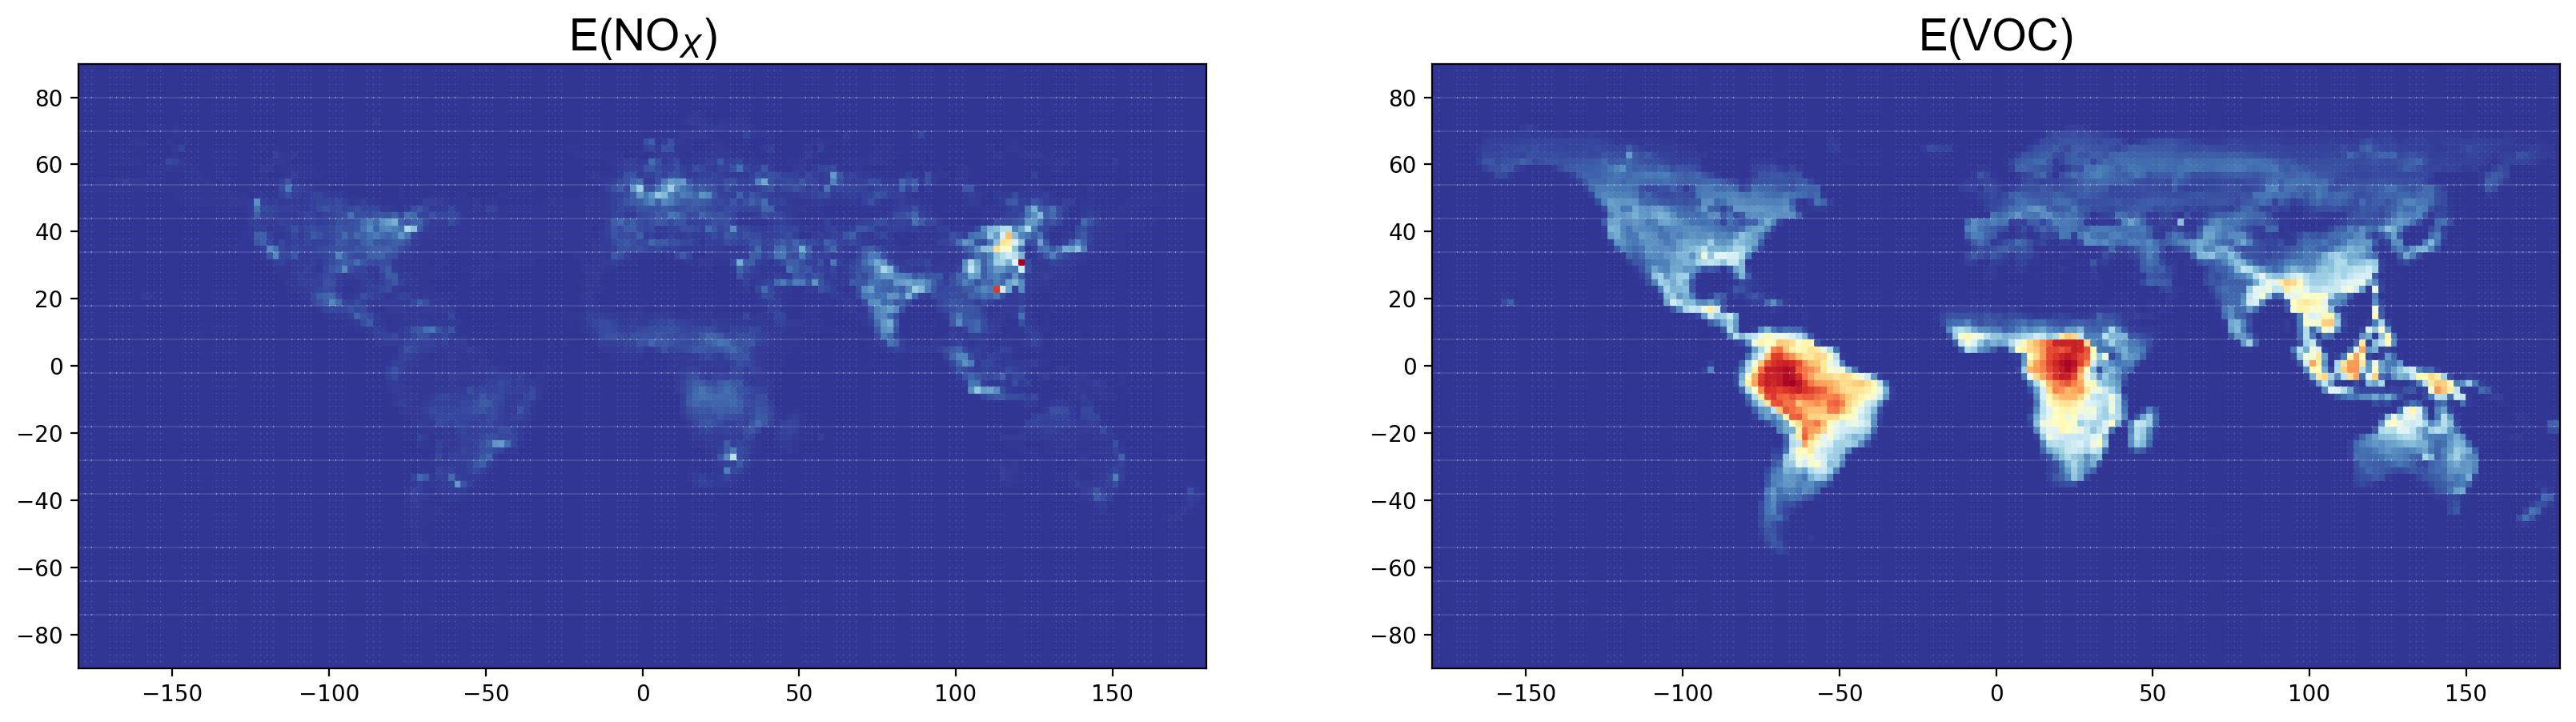

In [33]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,2,1)
plt.title('E(NO${_X}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['eminox'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,2,2)
plt.title('E(VOC)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['emivoc'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

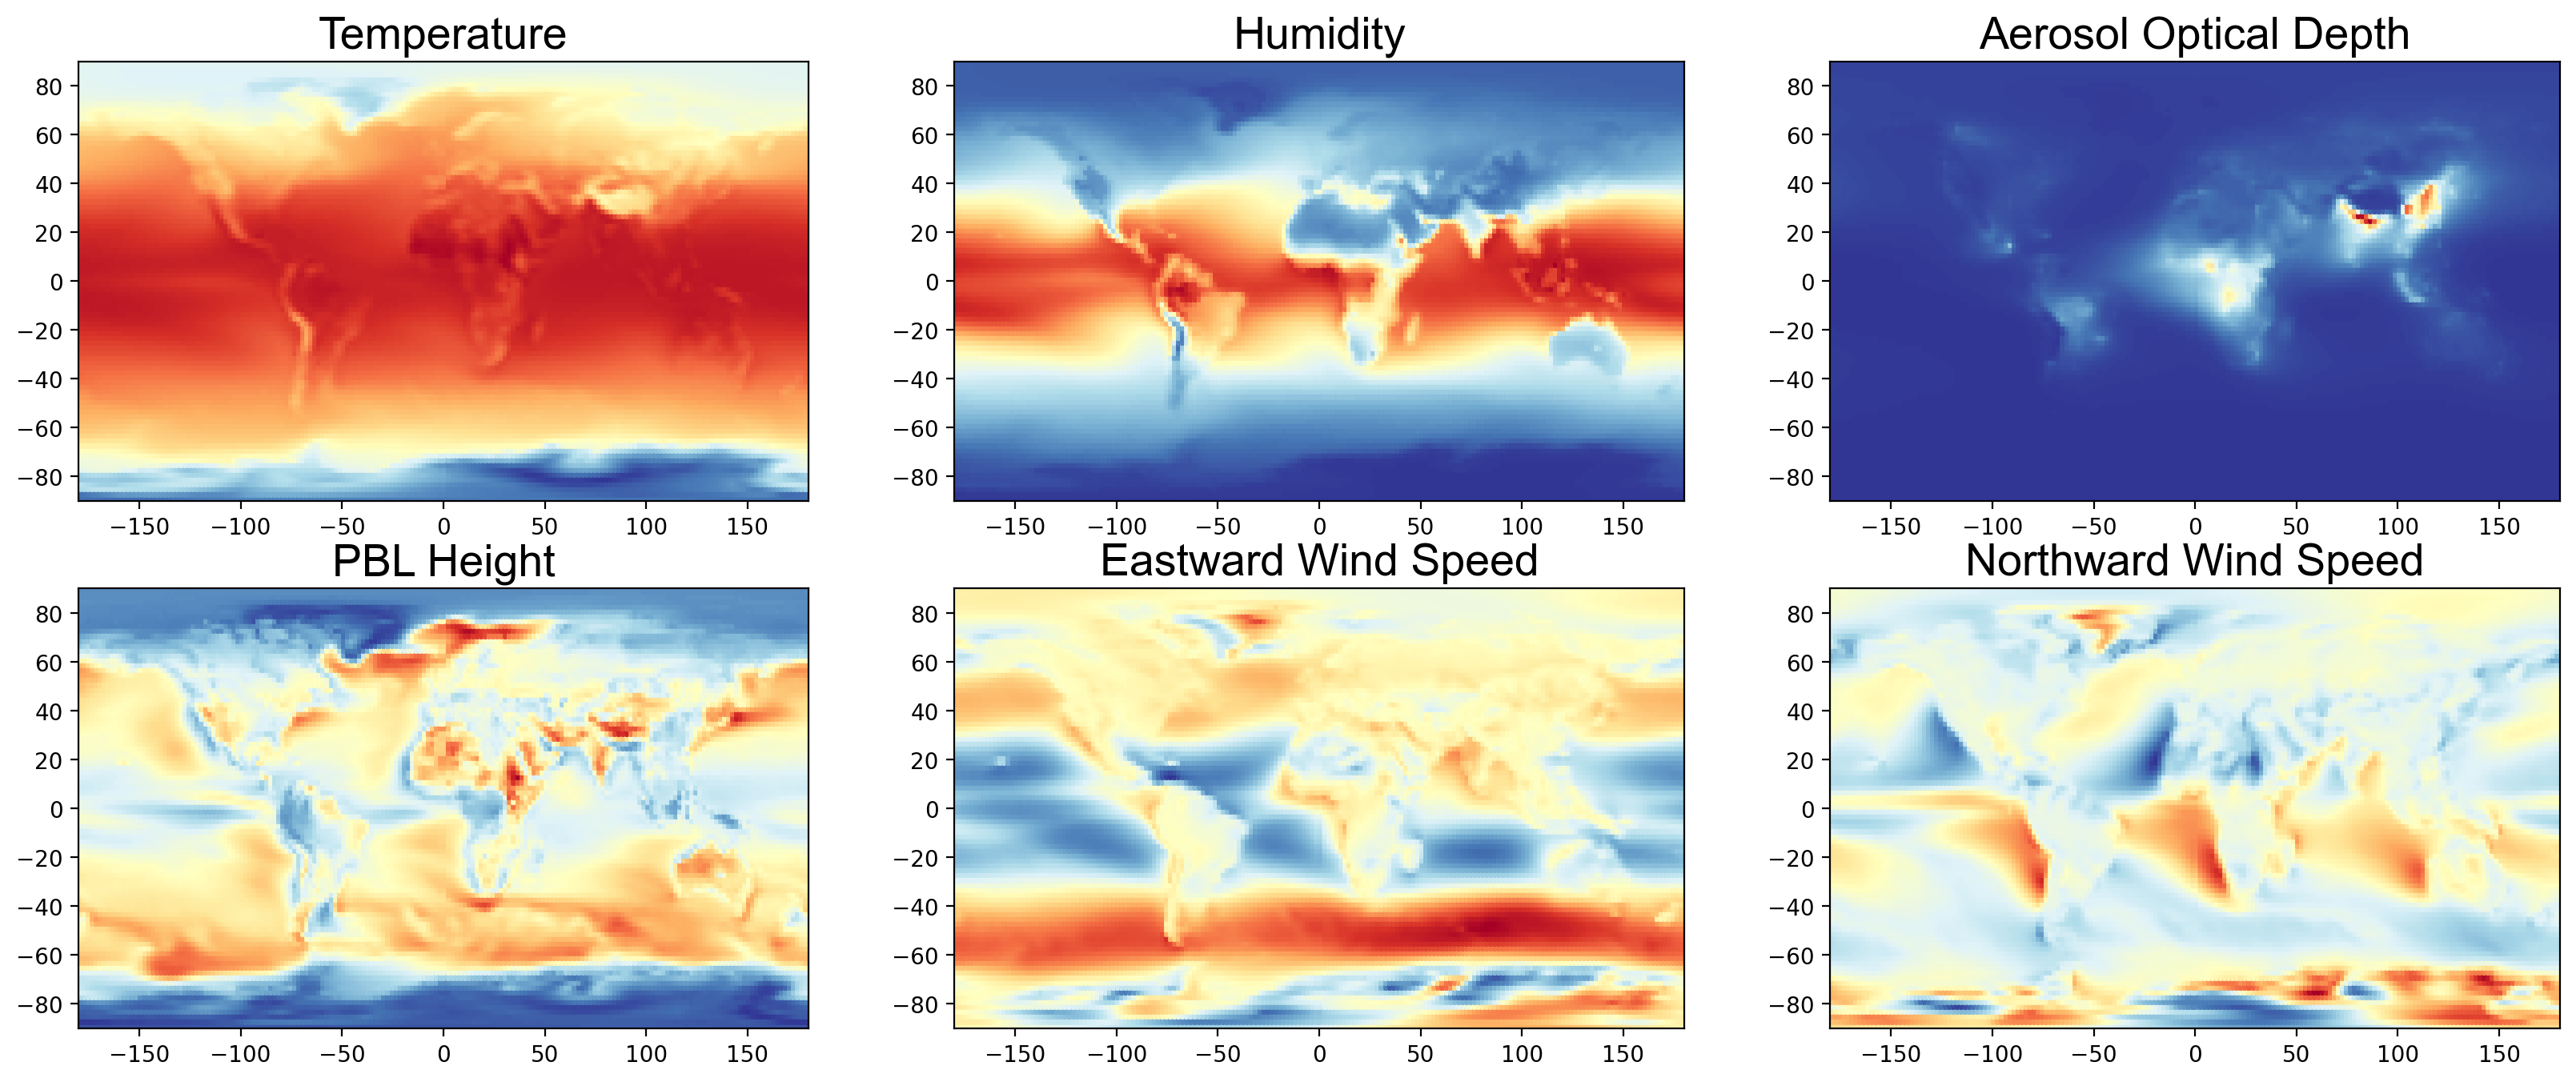

In [34]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('Temperature', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['tas'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('Humidity', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hus'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('Aerosol Optical Depth', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['aod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('PBL Height', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['bldep'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('Eastward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ua'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('Northward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['va'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

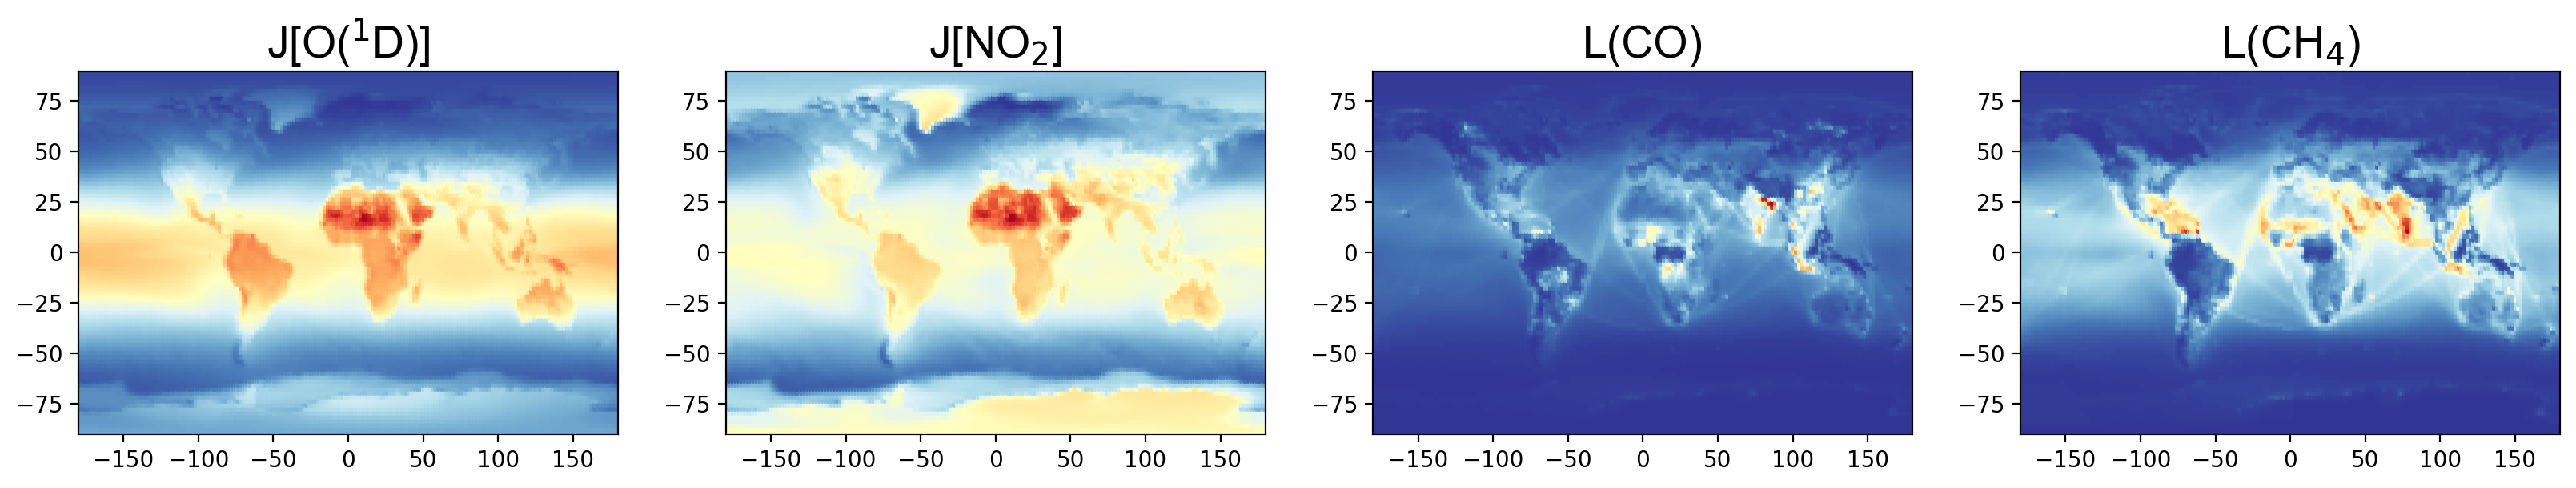

In [35]:
plt.figure(num=None, figsize=(20, 3), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title('J[O(${^1}$D)]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['photo1d'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,2)
plt.title('J[NO${_2}$]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['jno2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,3)
plt.title('L(CO)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossco'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,4)
plt.title('L(CH${_4}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

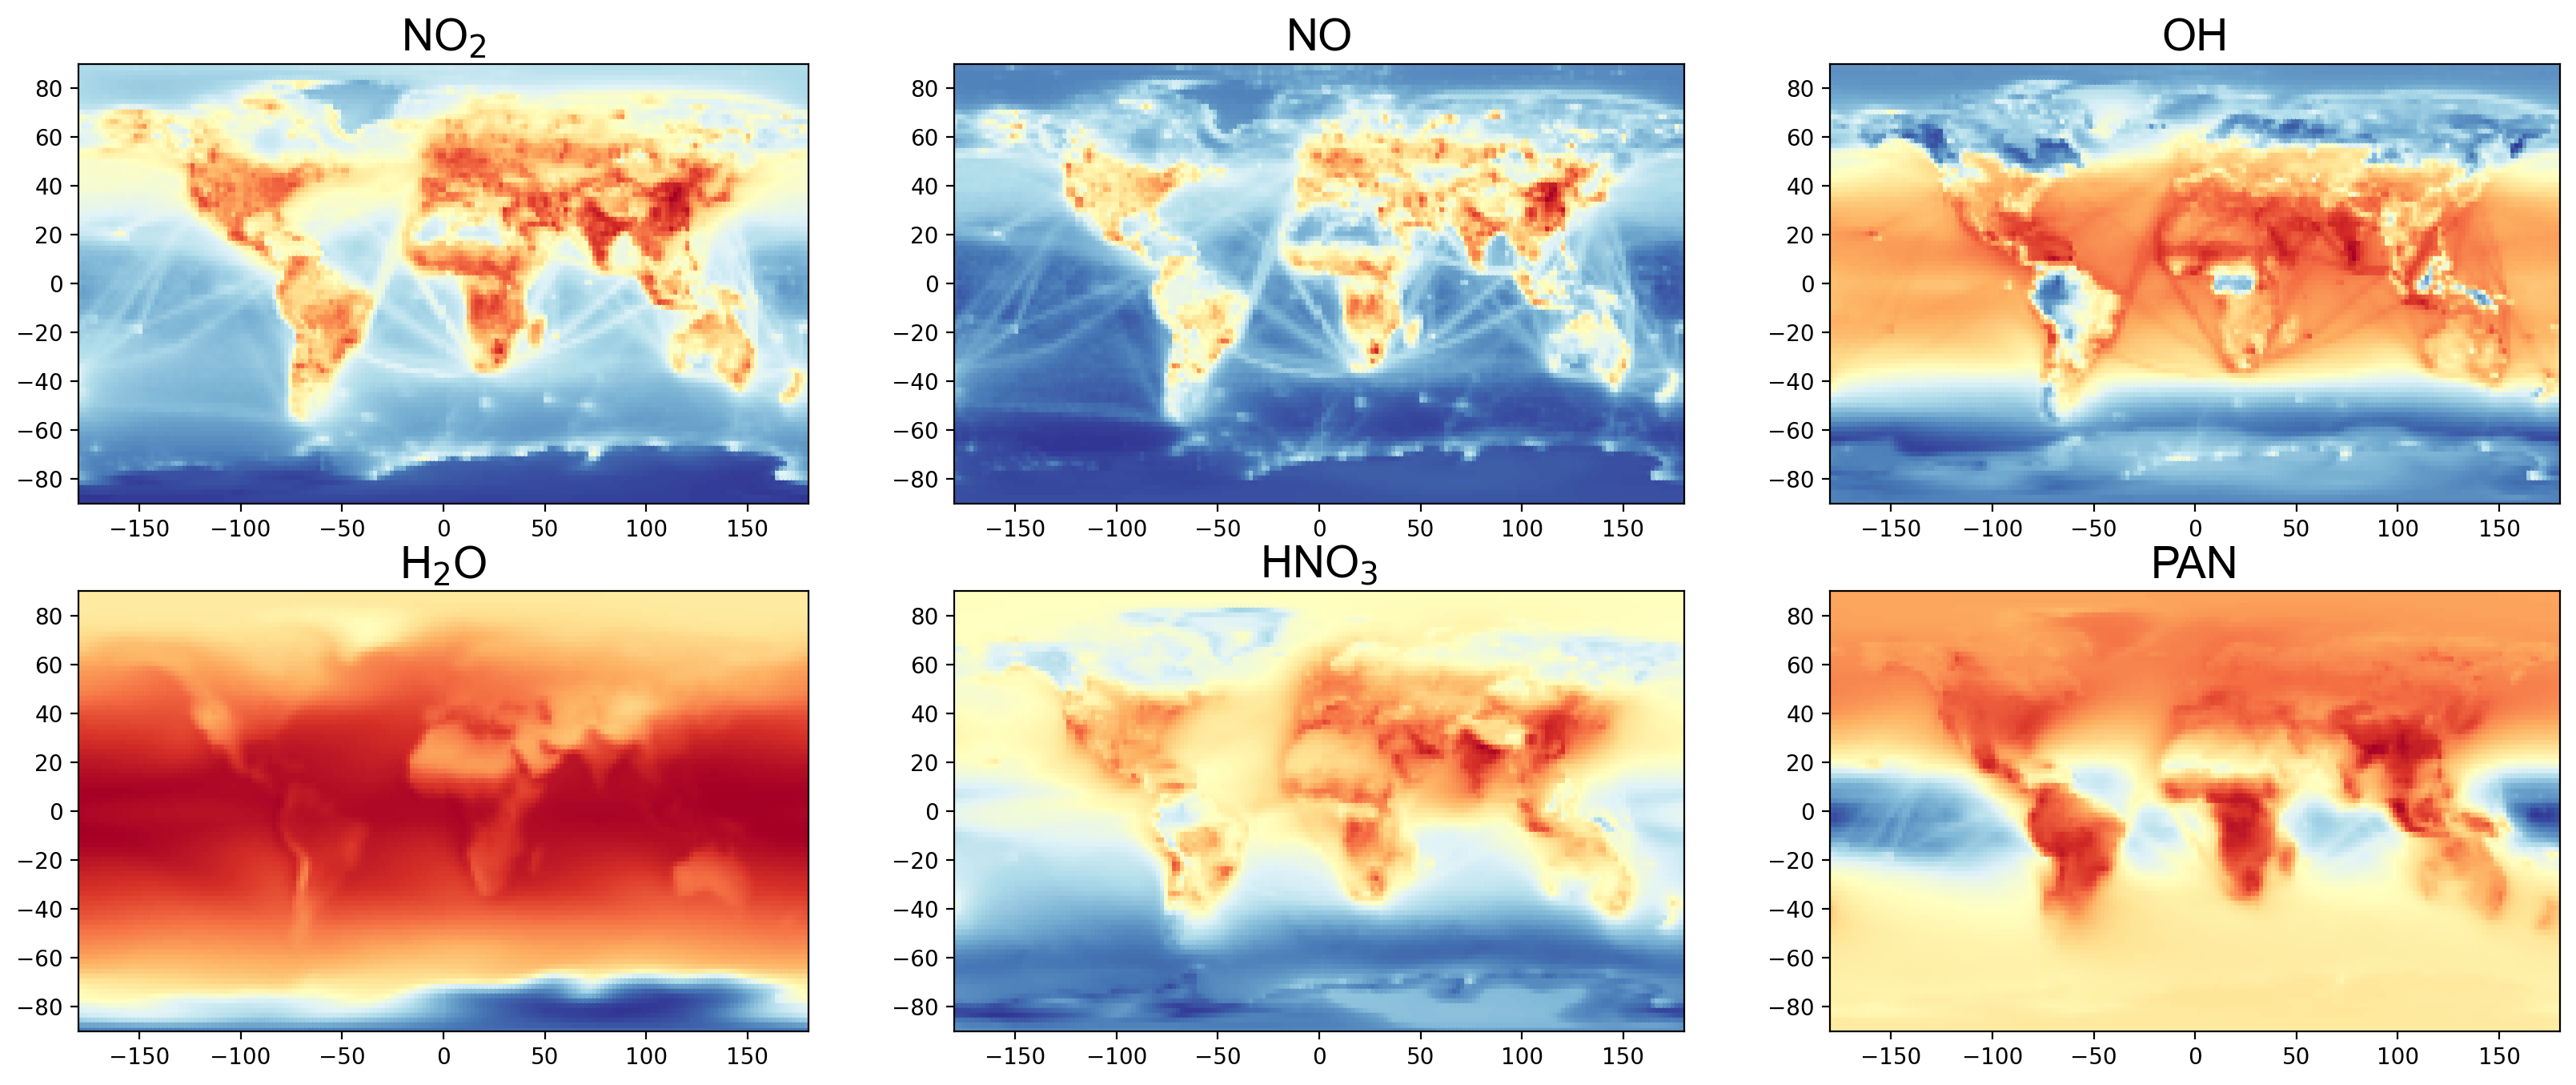

In [36]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('NO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('NO', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('H${_2}$O', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['h2o'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('HNO${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['hno3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('PAN', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['pan'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

#### We should now check whether each variable has been correctly extracted without any erroneous values (e.g. negative concentrations), and the sample sizes are all year×12×lon×lat. 

In [37]:
dataset_adj['eminox'].describe()

count    9.720000e+05
mean     5.765003e-12
std      2.158221e-11
min      0.000000e+00
25%      2.675547e-14
50%      3.133821e-13
75%      2.616661e-12
max      7.730638e-10
Name: eminox, dtype: float64

In [38]:
dataset_adj['emivoc'].describe()

count    9.720000e+05
mean     3.611763e-11
std      1.220769e-10
min      0.000000e+00
25%      4.175145e-14
50%      3.911541e-13
75%      1.478597e-12
max      4.046401e-09
Name: emivoc, dtype: float64

In [39]:
dataset_adj['o3'].describe()

count    9.720000e+05
mean     2.660710e-08
std      1.060254e-08
min      9.942245e-10
25%      1.866270e-08
50%      2.520061e-08
75%      3.230745e-08
max      1.137266e-07
Name: o3, dtype: float64

In [40]:
dataset_adj['o3prod'].describe()

count    9.720000e+05
mean     2.406040e-12
std      5.827643e-12
min      2.443647e-26
25%      6.936437e-14
50%      4.523633e-13
75%      1.886002e-12
max      3.054651e-10
Name: o3prod, dtype: float64

In [41]:
dataset_adj['o3loss'].describe()

count    9.720000e+05
mean     1.065405e-12
std      1.361178e-12
min      7.812600e-19
25%      6.071620e-14
50%      4.560050e-13
75%      1.701210e-12
max      1.952872e-11
Name: o3loss, dtype: float64

In [42]:
dataset_adj['tas'].describe()

count    972000.000000
mean        278.322906
std          22.166065
min         195.837143
25%         267.857590
50%         283.428085
75%         296.546234
max         313.929382
Name: tas, dtype: float64

In [43]:
dataset_adj['hus'].describe()

count    972000.000000
mean          0.006823
std           0.005682
min           0.000036
25%           0.002007
50%           0.005103
75%           0.011299
max           0.022799
Name: hus, dtype: float64

In [44]:
dataset_adj['aod'].describe()

count    972000.000000
mean          0.005057
std           0.011113
min           0.000040
25%           0.000410
50%           0.001826
75%           0.004752
max           0.336151
Name: aod, dtype: float64

In [45]:
dataset_adj['bldep'].describe()

count    972000.000000
mean        821.795166
std         416.171906
min          24.572105
25%         556.442154
50%         845.890015
75%        1097.296234
max        3580.801025
Name: bldep, dtype: float64

In [46]:
dataset_adj['ua'].describe()

count    972000.000000
mean         -0.100735
std           3.826984
min         -12.567708
25%          -2.369227
50%          -0.079874
75%           1.906804
max          12.466594
Name: ua, dtype: float64

In [47]:
dataset_adj['va'].describe()

count    972000.000000
mean          0.171134
std           2.398659
min         -11.440308
25%          -1.197710
50%           0.028811
75%           1.420211
max          12.885262
Name: va, dtype: float64

In [48]:
dataset_adj['jno2'].describe()

count    972000.000000
mean          0.002676
std           0.001920
min           0.000000
25%           0.001193
50%           0.002842
75%           0.003513
max           0.011400
Name: jno2, dtype: float64

In [49]:
dataset_adj['photo1d'].describe()

count    9.720000e+05
mean     5.424780e-06
std      4.641121e-06
min      0.000000e+00
25%      8.566926e-07
50%      4.710009e-06
75%      9.383633e-06
max      3.182525e-05
Name: photo1d, dtype: float64

In [50]:
dataset_adj['no2'].describe()

count    9.720000e+05
mean     5.399153e-10
std      2.000339e-09
min      9.556196e-14
25%      8.465431e-12
50%      3.266138e-11
75%      1.834651e-10
max      9.793162e-08
Name: no2, dtype: float64

In [51]:
dataset_adj['no'].describe()

count    9.720000e+05
mean     3.027983e-10
std      2.982863e-09
min      1.736107e-23
25%      1.621872e-12
50%      6.008761e-12
75%      3.698167e-11
max      2.354943e-07
Name: no, dtype: float64

In [52]:
dataset_adj['oh'].describe()

count    9.720000e+05
mean     4.347144e-14
std      4.620430e-14
min      2.527103e-20
25%      4.894383e-15
50%      2.668855e-14
75%      7.307805e-14
max      4.008437e-13
Name: oh, dtype: float64

In [53]:
dataset_adj['h2o'].describe()

count    972000.000000
mean          0.007513
std           0.006069
min           0.000009
25%           0.002476
50%           0.005777
75%           0.012529
max           0.022753
Name: h2o, dtype: float64

In [54]:
dataset_adj['hno3'].describe()

count    9.720000e+05
mean     2.722900e-10
std      7.316998e-10
min      2.726300e-13
25%      1.302109e-11
50%      6.646148e-11
75%      2.153471e-10
max      3.446845e-08
Name: hno3, dtype: float64

In [55]:
dataset_adj['pan'].describe()

count    9.720000e+05
mean     7.264653e-11
std      1.142996e-10
min      7.340827e-14
25%      1.465930e-11
50%      2.751836e-11
75%      9.467236e-11
max      6.416653e-09
Name: pan, dtype: float64

In [56]:
dataset_adj['lossco'].describe()

count    9.720000e+05
mean     8.215092e-13
std      1.199143e-12
min      6.252252e-19
25%      8.007349e-14
50%      4.375561e-13
75%      1.180056e-12
max      8.036397e-11
Name: lossco, dtype: float64

In [57]:
dataset_adj['lossch4'].describe()

count    9.720000e+05
mean     4.434949e-13
std      5.212248e-13
min      9.066387e-20
25%      2.929473e-14
50%      2.056441e-13
75%      7.776029e-13
max      4.549195e-12
Name: lossch4, dtype: float64

#### We should then check the scale of the kinetic rate coefficients with the IUPAC suggested values. 

##### The preferred value as 8.5×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [72]:
dataset_adj['k_no_ho2'].median()

8.555249512195586e-12

##### The preferred value as 7.7×10$^{–12}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [71]:
dataset_adj['k_no_ch3o2'].median()

8.191299915313721e-12

##### The preferred value as 2.14×10$^{–10}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [70]:
dataset_adj['k_o1d_h2o'].median()

2.014304496049881e-10

##### The preferred value as 2.0×10$^{–15}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [69]:
dataset_adj['k_o3_ho2'].median()

1.805485290327477e-15

##### The preferred value as 7.3×10$^{–14}$ cm$^3$ molecule$^{-1}$ s$^{-1}$ at 298 K.

In [68]:
dataset_adj['k_o3_oh'].median()

6.167295798659324e-14